In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json



In [2]:
# dataset link
# https://www.kaggle.com/datasets/kasikrit/308-456-dogs-vs-cats-dataset

In [3]:
!kaggle datasets download -d kasikrit/308-456-dogs-vs-cats-dataset

 99% 540M/546M [00:13<00:00, 28.5MB/s]
100% 546M/546M [00:13<00:00, 43.6MB/s]


In [4]:
import zipfile
zip_ref=zipfile.ZipFile('/content/308-456-dogs-vs-cats-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [20]:
input_shape = (150, 150, 3)
img_width = 150
img_height = 150
batch_size = 32
train_data = '/content/dataset_dogs_vs_cats/train'
validation_data = '/content/dataset_dogs_vs_cats/valid'


In [21]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [22]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [23]:
validation_datagen = ImageDataGenerator(rescale=1./255)


In [24]:
# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 18697 images belonging to 2 classes.


In [25]:

validation_generator = validation_datagen.flow_from_directory(
    validation_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # No need to shuffle validation data
)

Found 6303 images belonging to 2 classes.


In [ ]:
# Create the directory if it doesn't exist
os.makedirs("/content/Colab_Notebooks/", exist_ok=True)


In [ ]:
# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("/content/Colab_Notebooks/model_checkpoint.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=10,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              min_lr=0.00001,
                              verbose=1)

In [ ]:
# Fit the model
epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    callbacks=[checkpoint, earlystop, reduce_lr],
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/50
585/585 [==============================] - ETA: 0s - loss: 0.6795 - accuracy: 0.5591
Epoch 1: val_loss improved from inf to 0.63760, saving model to /content/Colab_Notebooks/model_checkpoint.h5
585/585 [==============================] - 156s 253ms/step - loss: 0.6795 - accuracy: 0.5591 - val_loss: 0.6376 - val_accuracy: 0.6254 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
585/585 [==============================] - ETA: 0s - loss: 0.6280 - accuracy: 0.6421
Epoch 2: val_loss improved from 0.63760 to 0.56056, saving model to /content/Colab_Notebooks/model_checkpoint.h5
585/585 [==============================] - 143s 244ms/step - loss: 0.6280 - accuracy: 0.6421 - val_loss: 0.5606 - val_accuracy: 0.7205 - lr: 0.0010
Epoch 3/50
585/585 [==============================] - ETA: 0s - loss: 0.5894 - accuracy: 0.6840
Epoch 3: val_loss improved from 0.56056 to 0.50840, saving model to /content/Colab_Notebooks/model_checkpoint.h5
585/585 [==============================] - 145s 248ms/step - loss: 0.5894 - accuracy: 0.6840 - val_loss: 0.5084 - val_accuracy: 0.7557 - lr: 0.0010
Epoch 4/50
585/585 [==============================] - ETA: 0s - loss: 0.5581 - accuracy: 0.7119
Epoch 4: val_loss did not improve from 0.50840
585/585 [==============================] - 145s 248ms/step - loss: 0.5581 - accuracy: 0.7119 - val_loss: 0.5652 - val_accuracy: 0.7089 - lr: 0.

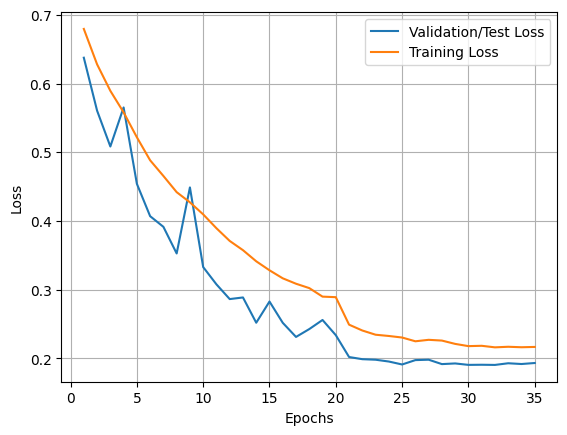

In [ ]:
# Plotting our loss chart
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

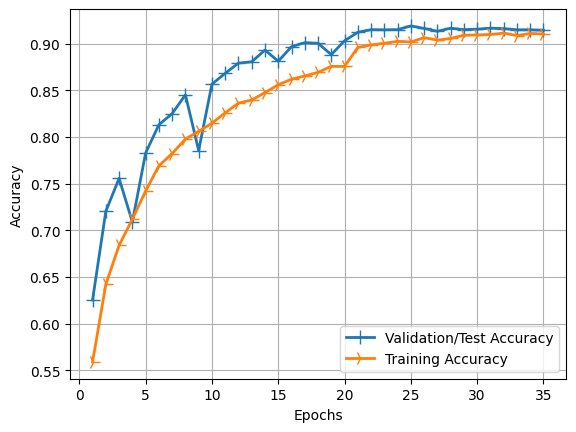

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

random image number:  117
(32, 150, 150, 3) (32,)
[1. 1. 0. 0. 1. 0. 1. 1. 1. 1.]


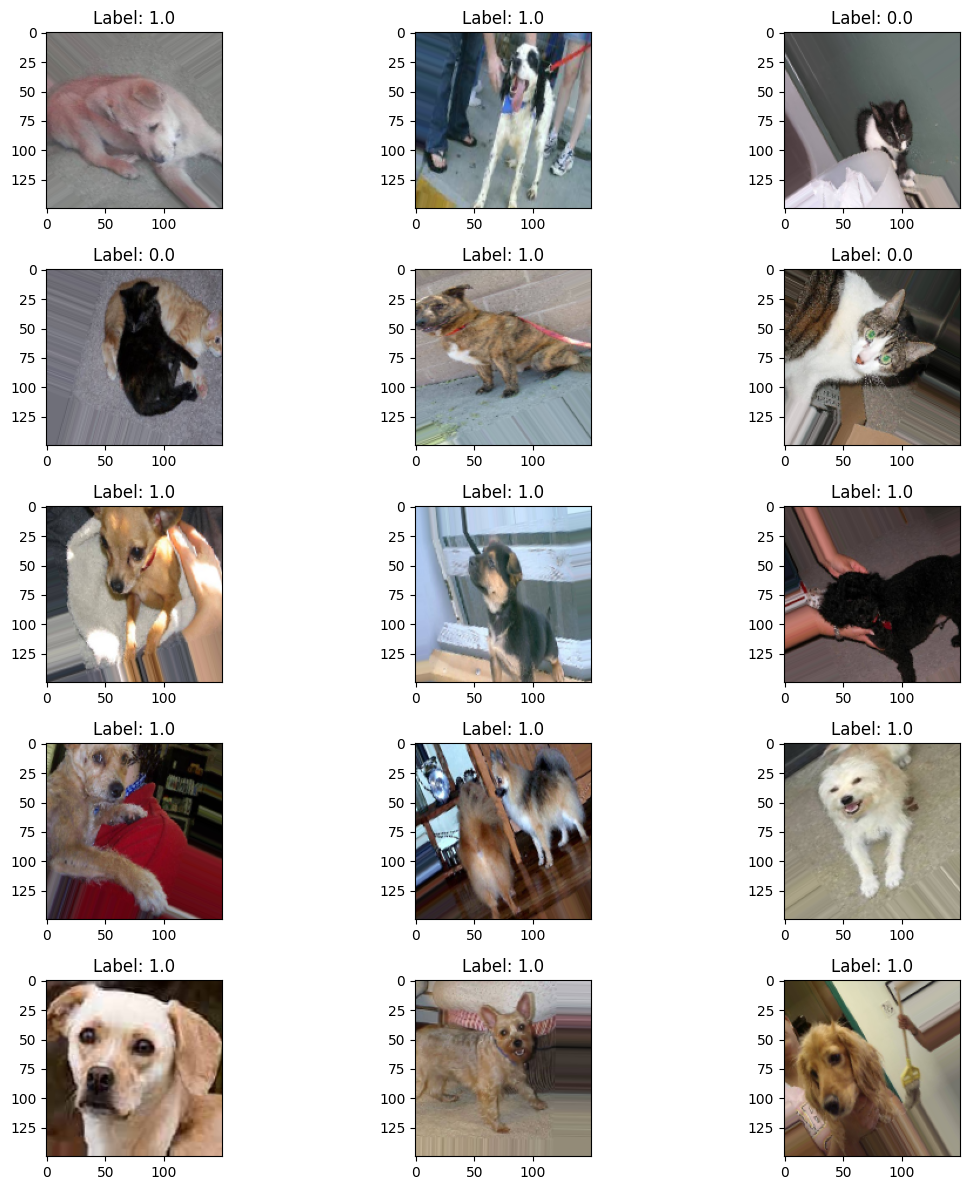

In [12]:
import random
image_number = random.randint(0, len(train_generator))
print('random image number: ', image_number)
X_batch, y_batch = train_generator.__getitem__(image_number) #dudder method
print(X_batch.shape, y_batch.shape)
print(y_batch[:10])

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    image = X_batch[i]
    plt.imshow(image)
    plt.title("Label: " + str(y_batch[i]))
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 123ms/step
[[0.]]


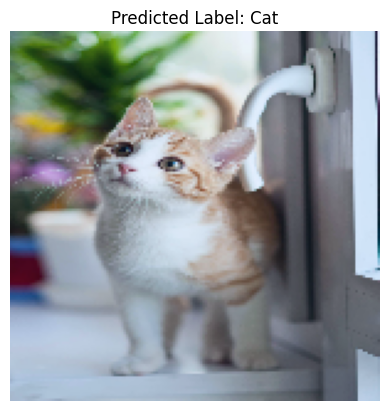

In [18]:
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import matplotlib.pyplot as plt

# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(150, 150))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 150, 150, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

# load an image and predict the class
def run_example():
    # load the image
    img = load_image('/content/pexels-wojciech-kumpicki-2071873.jpg')
    # load model
    model = load_model('/content/DogVSCat.h5')
    # predict the class
    result = model.predict(img)
    print (result)

    # Convert the predicted probability to a class label
    if result[0] > 0.5:
        label = 'Dog'
    else:
        label = 'Cat'

    # Convert the array back to image
    img = array_to_img(img[0])

    # Display the image
    plt.imshow(img)
    plt.title('Predicted Label: ' + label)
    plt.axis('off')
    plt.show()

# entry point, run the example
run_example()

In [ ]:
# Evaluate the model on the validation set
evaluation = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Loss: {evaluation[0]}, Validatoion Accuracy: {evaluation[1]}")


196/196 [==============================] - 17s 86ms/step - loss: 0.1915 - accuracy: 0.9188
Validation Loss: 0.19153784215450287, Validation Accuracy: 0.9188456535339355
